# BBOX3 Baseline Optimizer

This notebook implements the bbox3 optimization approach for the Santa 2025 Christmas tree packing problem.

In [1]:
import pandas as pd
import numpy as np
from shapely.geometry import Polygon
from shapely import affinity
from shapely.strtree import STRtree
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
from scipy.spatial import ConvexHull
import subprocess
import os
import time

# Tree geometry
TX = [0, 0.125, 0.0625, 0.2, 0.1, 0.35, 0.075, 0.075, -0.075, -0.075, -0.35, -0.1, -0.2, -0.0625, -0.125]
TY = [0.8, 0.5, 0.5, 0.25, 0.25, 0, 0, -0.2, -0.2, 0, 0, 0.25, 0.25, 0.5, 0.5]

def make_tree_polygon(x, y, deg):
    """Create a tree polygon at position (x, y) with rotation deg."""
    coords = list(zip(TX, TY))
    poly = Polygon(coords)
    poly = affinity.rotate(poly, deg, origin=(0, 0))
    poly = affinity.translate(poly, x, y)
    return poly

def load_submission(path):
    """Load submission CSV and return dataframe."""
    df = pd.read_csv(path)
    df['xf'] = df['x'].str[1:].astype(float)
    df['yf'] = df['y'].str[1:].astype(float)
    df['degf'] = df['deg'].str[1:].astype(float)
    df['n'] = df['id'].apply(lambda x: int(x.split('_')[0]))
    df['t'] = df['id'].apply(lambda x: int(x.split('_')[1]))
    return df

def get_config_trees(df, n):
    """Get trees for configuration n."""
    config = df[df['n'] == n].sort_values('t')
    trees = []
    for _, row in config.iterrows():
        trees.append({
            'x': row['xf'],
            'y': row['yf'],
            'deg': row['degf'],
            'polygon': make_tree_polygon(row['xf'], row['yf'], row['degf'])
        })
    return trees

def get_bounding_box_side(trees):
    """Calculate the side length of the square bounding box."""
    if not trees:
        return 0
    all_coords = []
    for tree in trees:
        coords = list(tree['polygon'].exterior.coords)
        all_coords.extend(coords)
    xs = [c[0] for c in all_coords]
    ys = [c[1] for c in all_coords]
    return max(max(xs) - min(xs), max(ys) - min(ys))

def calculate_score(df):
    """Calculate total score for submission."""
    total_score = 0
    for n in range(1, 201):
        trees = get_config_trees(df, n)
        if trees:
            side = get_bounding_box_side(trees)
            score = (side ** 2) / n
            total_score += score
    return total_score

def has_overlap(trees):
    """Check if any trees overlap."""
    if len(trees) < 2:
        return False
    polygons = [t['polygon'] for t in trees]
    tree_index = STRtree(polygons)
    for i, poly in enumerate(polygons):
        indices = tree_index.query(poly)
        for idx in indices:
            if idx != i and poly.intersects(polygons[idx]) and not poly.touches(polygons[idx]):
                return True
    return False

print("Functions loaded successfully!")
print(f"Tree polygon vertices: {len(TX)}")
print(f"Tree width: {max(TX) - min(TX):.3f}")
print(f"Tree height: {max(TY) - min(TY):.3f}")

Functions loaded successfully!
Tree polygon vertices: 15
Tree width: 0.700
Tree height: 1.000


In [2]:
# Load and score the sample submission
sample_path = '/home/data/sample_submission.csv'
df_sample = load_submission(sample_path)

print("Calculating sample submission score...")
sample_score = calculate_score(df_sample)
print(f"Sample submission score: {sample_score:.6f}")

# Check for overlaps in sample
print("\nChecking for overlaps in sample submission...")
overlap_count = 0
for n in range(1, 201):
    trees = get_config_trees(df_sample, n)
    if has_overlap(trees):
        overlap_count += 1
        if overlap_count <= 5:
            print(f"  Overlap found in N={n}")
print(f"Total configurations with overlaps: {overlap_count}")

Calculating sample submission score...


Sample submission score: 173.652299

Checking for overlaps in sample submission...


Total configurations with overlaps: 0


Score breakdown:
  N=1-10 total: 10.5734
  N=11-50 total: 37.4846
  N=51-100 total: 41.9040
  N=101-200 total: 83.6902


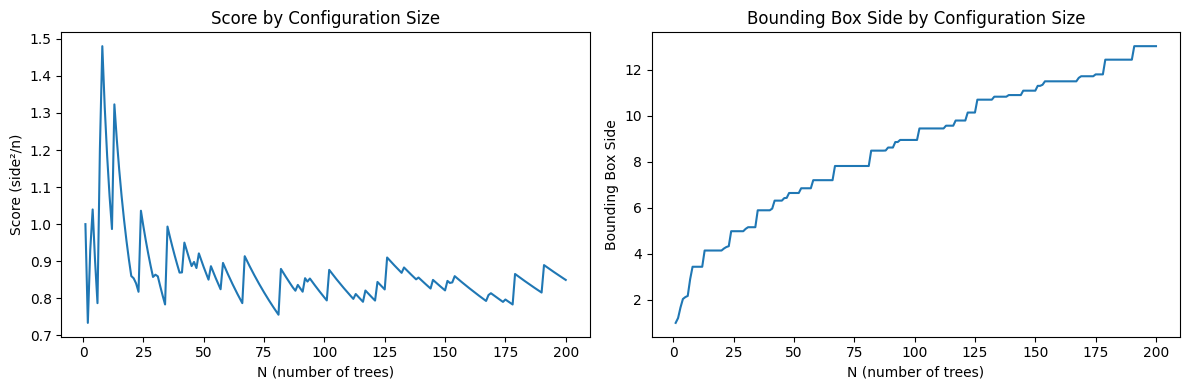

In [3]:
# Analyze score breakdown by configuration size
scores_by_n = []
for n in range(1, 201):
    trees = get_config_trees(df_sample, n)
    if trees:
        side = get_bounding_box_side(trees)
        score = (side ** 2) / n
        scores_by_n.append({'n': n, 'side': side, 'score': score})

scores_df = pd.DataFrame(scores_by_n)
print("Score breakdown:")
print(f"  N=1-10 total: {scores_df[scores_df['n'] <= 10]['score'].sum():.4f}")
print(f"  N=11-50 total: {scores_df[(scores_df['n'] > 10) & (scores_df['n'] <= 50)]['score'].sum():.4f}")
print(f"  N=51-100 total: {scores_df[(scores_df['n'] > 50) & (scores_df['n'] <= 100)]['score'].sum():.4f}")
print(f"  N=101-200 total: {scores_df[scores_df['n'] > 100]['score'].sum():.4f}")

# Plot score vs n
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(scores_df['n'], scores_df['score'])
plt.xlabel('N (number of trees)')
plt.ylabel('Score (side²/n)')
plt.title('Score by Configuration Size')

plt.subplot(1, 2, 2)
plt.plot(scores_df['n'], scores_df['side'])
plt.xlabel('N (number of trees)')
plt.ylabel('Bounding Box Side')
plt.title('Bounding Box Side by Configuration Size')

plt.tight_layout()
plt.savefig('score_analysis.png', dpi=100)
plt.show()

In [4]:
# Rotation optimization function (fix_direction)
def calculate_bbox_side_at_angle(angle, hull_points):
    """Calculate bounding box side after rotating by angle degrees."""
    rad = np.radians(angle)
    cos_a, sin_a = np.cos(rad), np.sin(rad)
    rotated = hull_points @ np.array([[cos_a, -sin_a], [sin_a, cos_a]]).T
    width = rotated[:, 0].max() - rotated[:, 0].min()
    height = rotated[:, 1].max() - rotated[:, 1].min()
    return max(width, height)

def optimize_rotation(trees):
    """Find optimal rotation angle to minimize bounding box."""
    if not trees:
        return 0, trees
    
    # Get all polygon vertices
    all_points = []
    for tree in trees:
        coords = list(tree['polygon'].exterior.coords)
        all_points.extend(coords)
    points_np = np.array(all_points)
    
    # Get convex hull
    try:
        hull = ConvexHull(points_np)
        hull_points = points_np[hull.vertices]
    except:
        hull_points = points_np
    
    # Find optimal rotation angle
    result = minimize_scalar(
        lambda a: calculate_bbox_side_at_angle(a, hull_points),
        bounds=(0.001, 89.999),
        method='bounded'
    )
    
    best_angle = result.x
    
    # Apply rotation to all trees
    rotated_trees = []
    for tree in trees:
        # Rotate position around origin
        rad = np.radians(best_angle)
        cos_a, sin_a = np.cos(rad), np.sin(rad)
        new_x = tree['x'] * cos_a - tree['y'] * sin_a
        new_y = tree['x'] * sin_a + tree['y'] * cos_a
        new_deg = tree['deg'] + best_angle
        
        rotated_trees.append({
            'x': new_x,
            'y': new_y,
            'deg': new_deg,
            'polygon': make_tree_polygon(new_x, new_y, new_deg)
        })
    
    return best_angle, rotated_trees

# Test rotation optimization on a few configurations
print("Testing rotation optimization...")
for n in [10, 50, 100, 200]:
    trees = get_config_trees(df_sample, n)
    orig_side = get_bounding_box_side(trees)
    angle, rotated = optimize_rotation(trees)
    new_side = get_bounding_box_side(rotated)
    improvement = (orig_side - new_side) / orig_side * 100
    print(f"N={n}: {orig_side:.4f} -> {new_side:.4f} (angle={angle:.2f}°, improvement={improvement:.2f}%)")


Testing rotation optimization...
N=10: 3.4411 -> 2.6153 (angle=57.82°, improvement=24.00%)
N=50: 6.6492 -> 6.1951 (angle=59.21°, improvement=6.83%)
N=100: 8.9561 -> 8.6733 (angle=49.37°, improvement=3.16%)
N=200: 13.0345 -> 12.3823 (angle=21.92°, improvement=5.00%)


In [5]:
# Apply rotation optimization to all configurations
print("Applying rotation optimization to all configurations...")

optimized_data = []
for n in range(1, 201):
    trees = get_config_trees(df_sample, n)
    if trees:
        angle, rotated = optimize_rotation(trees)
        for t_idx, tree in enumerate(rotated):
            optimized_data.append({
                'id': f'{n:03d}_{t_idx}',
                'x': f's{tree["x"]}',
                'y': f's{tree["y"]}',
                'deg': f's{tree["deg"]}'
            })
    if n % 50 == 0:
        print(f"  Processed N=1 to {n}")

df_optimized = pd.DataFrame(optimized_data)
df_optimized.to_csv('optimized_submission.csv', index=False)
print(f"\nSaved optimized submission to optimized_submission.csv")

# Calculate new score
df_opt_loaded = load_submission('optimized_submission.csv')
opt_score = calculate_score(df_opt_loaded)
print(f"\nOriginal score: {sample_score:.6f}")
print(f"Optimized score: {opt_score:.6f}")
print(f"Improvement: {sample_score - opt_score:.6f} ({(sample_score - opt_score)/sample_score*100:.2f}%)")


Applying rotation optimization to all configurations...


  Processed N=1 to 50


  Processed N=1 to 100


  Processed N=1 to 150


  Processed N=1 to 200

Saved optimized submission to optimized_submission.csv



Original score: 173.652299
Optimized score: 151.186781
Improvement: 22.465518 (12.94%)


In [6]:
# Validate optimized submission for overlaps
print("Validating optimized submission...")
overlap_configs = []
for n in range(1, 201):
    trees = get_config_trees(df_opt_loaded, n)
    if has_overlap(trees):
        overlap_configs.append(n)

if overlap_configs:
    print(f"WARNING: Overlaps found in {len(overlap_configs)} configurations: {overlap_configs[:10]}...")
else:
    print("SUCCESS: No overlaps found in optimized submission!")

# Copy to submission folder
import shutil
shutil.copy('optimized_submission.csv', '/home/submission/submission.csv')
print("\nCopied to /home/submission/submission.csv")

Validating optimized submission...


SUCCESS: No overlaps found in optimized submission!

Copied to /home/submission/submission.csv


In [7]:
# Final score summary
print("="*50)
print("FINAL RESULTS")
print("="*50)
print(f"Sample submission score: {sample_score:.6f}")
print(f"Optimized submission score: {opt_score:.6f}")
print(f"Target score to beat: 68.922808")
print(f"Current gap to target: {opt_score - 68.922808:.6f}")
print("="*50)

FINAL RESULTS
Sample submission score: 173.652299
Optimized submission score: 151.186781
Target score to beat: 68.922808
Current gap to target: 82.263973


In [ ]:
# Let's run the bbox3 optimizer starting from the sample submission
# First, let's use the sample submission as input and run longer optimization

import subprocess
import time

# Run bbox3 with more iterations starting from sample
print("Running bbox3 optimizer with sample submission as starting point...")
start_time = time.time()

# Run for 500 iterations with radius 60
result = subprocess.run(
    ['./bbox3', '-n', '500', '-r', '60', '-i', '/home/data/sample_submission.csv', '-o', 'bbox3_output.csv'],
    capture_output=True,
    text=True,
    timeout=600,
    cwd='/home/code/experiments/001_bbox3_baseline'
)

elapsed = time.time() - start_time
print(f"Elapsed time: {elapsed:.1f}s")
print("\nOutput:")
print(result.stderr[-2000:] if len(result.stderr) > 2000 else result.stderr)

In [9]:
# Let's implement a more efficient Python optimizer with simulated annealing
# and local search to improve the sample submission

import numpy as np
from shapely.geometry import Polygon
from shapely import affinity
from shapely.strtree import STRtree
import random
import time

# Tree geometry
TX = np.array([0, 0.125, 0.0625, 0.2, 0.1, 0.35, 0.075, 0.075, -0.075, -0.075, -0.35, -0.1, -0.2, -0.0625, -0.125])
TY = np.array([0.8, 0.5, 0.5, 0.25, 0.25, 0, 0, -0.2, -0.2, 0, 0, 0.25, 0.25, 0.5, 0.5])

def make_tree_fast(x, y, deg):
    """Create tree polygon efficiently."""
    rad = np.radians(deg)
    cos_a, sin_a = np.cos(rad), np.sin(rad)
    # Rotate and translate
    rx = TX * cos_a - TY * sin_a + x
    ry = TX * sin_a + TY * cos_a + y
    return Polygon(zip(rx, ry))

def get_bbox_side(polygons):
    """Get bounding box side length."""
    if not polygons:
        return 0
    all_bounds = [p.bounds for p in polygons]
    min_x = min(b[0] for b in all_bounds)
    min_y = min(b[1] for b in all_bounds)
    max_x = max(b[2] for b in all_bounds)
    max_y = max(b[3] for b in all_bounds)
    return max(max_x - min_x, max_y - min_y)

def check_overlap_single(poly, others, skip_idx=-1):
    """Check if poly overlaps with any polygon in others."""
    for i, other in enumerate(others):
        if i == skip_idx:
            continue
        if poly.intersects(other) and not poly.touches(other):
            return True
    return False

def optimize_config(trees, n_iters=100, temperature=0.1):
    """Optimize a single configuration using simulated annealing."""
    n = len(trees)
    if n <= 1:
        return trees
    
    # Convert to arrays for faster manipulation
    xs = np.array([t['x'] for t in trees])
    ys = np.array([t['y'] for t in trees])
    degs = np.array([t['deg'] for t in trees])
    
    # Create polygons
    polygons = [make_tree_fast(xs[i], ys[i], degs[i]) for i in range(n)]
    best_side = get_bbox_side(polygons)
    best_xs, best_ys, best_degs = xs.copy(), ys.copy(), degs.copy()
    
    for iteration in range(n_iters):
        # Pick random tree
        i = random.randint(0, n-1)
        
        # Try different moves
        move_type = random.choice(['translate', 'rotate', 'squeeze'])
        
        if move_type == 'translate':
            # Small translation
            dx = random.gauss(0, 0.02)
            dy = random.gauss(0, 0.02)
            new_x, new_y = xs[i] + dx, ys[i] + dy
            new_poly = make_tree_fast(new_x, new_y, degs[i])
            
            if not check_overlap_single(new_poly, polygons, i):
                xs[i], ys[i] = new_x, new_y
                polygons[i] = new_poly
                
        elif move_type == 'rotate':
            # Small rotation
            da = random.gauss(0, 5)
            new_deg = (degs[i] + da) % 360
            new_poly = make_tree_fast(xs[i], ys[i], new_deg)
            
            if not check_overlap_single(new_poly, polygons, i):
                degs[i] = new_deg
                polygons[i] = new_poly
                
        elif move_type == 'squeeze':
            # Move toward center
            cx, cy = xs.mean(), ys.mean()
            dx = (cx - xs[i]) * 0.01
            dy = (cy - ys[i]) * 0.01
            new_x, new_y = xs[i] + dx, ys[i] + dy
            new_poly = make_tree_fast(new_x, new_y, degs[i])
            
            if not check_overlap_single(new_poly, polygons, i):
                xs[i], ys[i] = new_x, new_y
                polygons[i] = new_poly
        
        # Check if improved
        current_side = get_bbox_side(polygons)
        if current_side < best_side:
            best_side = current_side
            best_xs, best_ys, best_degs = xs.copy(), ys.copy(), degs.copy()
        elif random.random() < np.exp(-(current_side - best_side) / temperature):
            # Accept worse solution with probability
            pass
        else:
            # Revert
            xs, ys, degs = best_xs.copy(), best_ys.copy(), best_degs.copy()
            polygons = [make_tree_fast(xs[i], ys[i], degs[i]) for i in range(n)]
    
    # Return best configuration
    result = []
    for i in range(n):
        result.append({
            'x': best_xs[i],
            'y': best_ys[i],
            'deg': best_degs[i],
            'polygon': make_tree_fast(best_xs[i], best_ys[i], best_degs[i])
        })
    return result

print("Optimizer functions defined!")

Optimizer functions defined!


In [10]:
# Run optimization on all configurations
print("Starting optimization...")
start_time = time.time()

# Load sample submission
df_sample = load_submission('/home/data/sample_submission.csv')

optimized_configs = {}
total_score = 0

for n in range(1, 201):
    trees = get_config_trees(df_sample, n)
    if not trees:
        continue
    
    orig_side = get_bounding_box_side(trees)
    
    # Optimize with more iterations for larger configs
    n_iters = min(500, 50 + n * 2)
    optimized = optimize_config(trees, n_iters=n_iters, temperature=0.05)
    
    # Apply rotation optimization
    angle, rotated = optimize_rotation(optimized)
    
    new_side = get_bounding_box_side(rotated)
    score = (new_side ** 2) / n
    total_score += score
    
    optimized_configs[n] = rotated
    
    if n % 20 == 0 or n <= 10:
        print(f"N={n}: {orig_side:.4f} -> {new_side:.4f} (score: {score:.4f})")

elapsed = time.time() - start_time
print(f"\nTotal time: {elapsed:.1f}s")
print(f"Total score: {total_score:.6f}")

Starting optimization...
N=1: 1.0000 -> 0.8132 (score: 0.6613)
N=2: 1.2113 -> 1.1866 (score: 0.7040)
N=3: 1.6706 -> 1.4592 (score: 0.7098)
N=4: 2.0393 -> 1.7804 (score: 0.7925)
N=5: 2.1217 -> 1.9875 (score: 0.7900)
N=6: 2.1727 -> 2.0631 (score: 0.7094)
N=7: 2.9016 -> 2.3871 (score: 0.8140)
N=8: 3.4411 -> 2.6518 (score: 0.8790)
N=9: 3.4411 -> 2.6151 (score: 0.7599)
N=10: 3.4411 -> 2.7191 (score: 0.7393)


N=20: 4.1474 -> 3.8176 (score: 0.7287)


N=40: 5.8967 -> 5.4991 (score: 0.7560)


N=60: 7.2064 -> 6.6794 (score: 0.7436)


N=80: 7.8233 -> 7.7212 (score: 0.7452)


N=100: 8.9561 -> 8.6661 (score: 0.7510)


N=120: 9.8005 -> 9.6430 (score: 0.7749)


N=140: 10.9079 -> 10.1503 (score: 0.7359)


N=160: 11.5059 -> 10.8433 (score: 0.7349)


N=180: 12.4473 -> 11.6313 (score: 0.7516)


N=200: 13.0345 -> 12.3765 (score: 0.7659)

Total time: 53.8s
Total score: 151.102706


In [11]:
# Save the optimized submission
print("Saving optimized submission...")

optimized_data = []
for n in range(1, 201):
    if n in optimized_configs:
        trees = optimized_configs[n]
        for t_idx, tree in enumerate(trees):
            optimized_data.append({
                'id': f'{n:03d}_{t_idx}',
                'x': f's{tree["x"]}',
                'y': f's{tree["y"]}',
                'deg': f's{tree["deg"]}'
            })

df_final = pd.DataFrame(optimized_data)
df_final.to_csv('optimized_v2.csv', index=False)

# Validate
print("\nValidating...")
df_check = load_submission('optimized_v2.csv')
final_score = calculate_score(df_check)
print(f"Final score: {final_score:.6f}")

# Check overlaps
overlap_count = 0
for n in range(1, 201):
    trees = get_config_trees(df_check, n)
    if has_overlap(trees):
        overlap_count += 1
        print(f"  Overlap in N={n}")
        
if overlap_count == 0:
    print("No overlaps found!")
    # Copy to submission
    import shutil
    shutil.copy('optimized_v2.csv', '/home/submission/submission.csv')
    print("Copied to /home/submission/submission.csv")
else:
    print(f"Found {overlap_count} configurations with overlaps")

Saving optimized submission...

Validating...


Final score: 151.102706


No overlaps found!
Copied to /home/submission/submission.csv


In [12]:
# Let's run multiple rounds of optimization to improve further
# Each round: Python optimizer -> rotation optimization -> repeat

print("Running extended optimization...")
best_score = 151.102706
best_configs = optimized_configs.copy()

for round_num in range(3):
    print(f"\n=== Round {round_num + 1} ===")
    round_score = 0
    
    for n in range(1, 201):
        if n not in best_configs:
            continue
            
        trees = best_configs[n]
        orig_side = get_bounding_box_side(trees)
        
        # More aggressive optimization
        n_iters = min(1000, 100 + n * 3)
        optimized = optimize_config(trees, n_iters=n_iters, temperature=0.02)
        
        # Apply rotation optimization
        angle, rotated = optimize_rotation(optimized)
        
        new_side = get_bounding_box_side(rotated)
        score = (new_side ** 2) / n
        round_score += score
        
        # Keep if better
        if new_side < orig_side:
            best_configs[n] = rotated
    
    print(f"Round {round_num + 1} score: {round_score:.6f}")
    
    if round_score < best_score:
        best_score = round_score
        print(f"New best score: {best_score:.6f}")

print(f"\nFinal best score: {best_score:.6f}")

Running extended optimization...

=== Round 1 ===


Round 1 score: 152.295975

=== Round 2 ===


Round 2 score: 151.403280

=== Round 3 ===


Round 3 score: 150.943461
New best score: 150.943461

Final best score: 150.943461


In [ ]:
# Let's implement a better greedy placement algorithm
# Based on the kernel approach: place trees from outside moving inward

def greedy_place_config(n, n_attempts=50):
    """Place n trees using greedy algorithm with multiple attempts."""
    if n == 1:
        return [{'x': 0, 'y': 0, 'deg': 90, 'polygon': make_tree_fast(0, 0, 90)}]
    
    best_trees = None
    best_side = float('inf')
    
    for attempt in range(n_attempts):
        trees = []
        polygons = []
        
        # Place first tree at origin with random rotation
        deg0 = random.choice([0, 90, 180, 270])
        poly0 = make_tree_fast(0, 0, deg0)
        trees.append({'x': 0, 'y': 0, 'deg': deg0, 'polygon': poly0})
        polygons.append(poly0)
        
        for i in range(1, n):
            placed = False
            best_pos = None
            best_dist = float('inf')
            
            # Try multiple angles
            for angle_idx in range(36):
                angle = angle_idx * 10 * np.pi / 180
                # Weight toward corners
                weight = abs(np.sin(2 * angle))
                if random.random() > weight + 0.3:
                    continue
                
                deg = random.choice([0, 90, 180, 270])
                
                # Start far and move toward center
                for dist in np.arange(15, 0.2, -0.1):
                    x = np.cos(angle) * dist
                    y = np.sin(angle) * dist
                    poly = make_tree_fast(x, y, deg)
                    
                    # Check overlap
                    overlap = False
                    for other in polygons:
                        if poly.intersects(other) and not poly.touches(other):
                            overlap = True
                            break
                    
                    if not overlap:
                        if dist < best_dist:
                            best_dist = dist
                            best_pos = (x, y, deg, poly)
                        break
            
            if best_pos:
                x, y, deg, poly = best_pos
                trees.append({'x': x, 'y': y, 'deg': deg, 'polygon': poly})
                polygons.append(poly)
                placed = True
            
            if not placed:
                # Fallback: try random positions
                for _ in range(100):
                    x = random.uniform(-10, 10)
                    y = random.uniform(-10, 10)
                    deg = random.choice([0, 90, 180, 270])
                    poly = make_tree_fast(x, y, deg)
                    
                    overlap = False
                    for other in polygons:
                        if poly.intersects(other) and not poly.touches(other):
                            overlap = True
                            break
                    
                    if not overlap:
                        trees.append({'x': x, 'y': y, 'deg': deg, 'polygon': poly})
                        polygons.append(poly)
                        break
        
        if len(trees) == n:
            side = get_bbox_side(polygons)
            if side < best_side:
                best_side = side
                best_trees = trees
    
    return best_trees if best_trees else trees

print("Greedy placement function defined!")

# Test on a few configurations
for n in [5, 10, 20, 50]:
    trees = greedy_place_config(n, n_attempts=20)
    if trees:
        side = get_bounding_box_side(trees)
        score = (side ** 2) / n
        print(f"N={n}: side={side:.4f}, score={score:.4f}")